In [9]:
# ==============================================================================
# LIBRARIES
# ==============================================================================
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import requests
import time
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# BioPython imports
from Bio.PDB import MMCIFParser
from Bio.PDB.Polypeptide import three_to_one
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

# ==============================================================================
# CONFIGURATION
# ==============================================================================
# --- File Paths ---
CIF_DIR = "../Data/CIF_Files/"
REP_CHAIN_FILE = "../Output/Binding_Residue/Rep_GPCR_chain.csv"
CLASSIFICATION_FILE = "../Output/Dynamics/GPCR_PDB_classification.csv"
SEQUENCE_INFO_FILE = '../Input/Human_GPCR_PDB_Info.csv'
OUTPUT_DIR = "../Output/Dynamics/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Output File Names ---
CONSENSUS_DYNAMICS_FILE = os.path.join(OUTPUT_DIR, "GPCR_Dynamics_Metrics_Consensus.csv")
LOG_FILE = os.path.join(OUTPUT_DIR, "processing_log_consensus.txt")

# Setup logging
logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w' # Overwrite the log file on each run
)
warnings.filterwarnings("ignore")


In [10]:
# ==============================================================================
# HELPER FUNCTIONS
# ==============================================================================
def parse_bw_number(bw_string):
    """Parses BW numbers like '1.50x50' or '1.50' into '1.50'."""
    if bw_string is None:
        return None
    return bw_string.split('x')[0]

def get_bw_map_from_gpcrdb(entry_name):
    """Fetches BW map from the GPCRdb API."""
    url = f"https://gpcrdb.org/services/residues/{entry_name.lower()}/"
    try:
        response = requests.get(url, timeout=20)
        response.raise_for_status()
        residues = response.json()
        if not residues: return None
        
        uniprot_to_bw = {
            res['sequence_number']: parse_bw_number(res['display_generic_number'])
            for res in residues if res.get('display_generic_number')
        }
        return uniprot_to_bw if uniprot_to_bw else None
    except requests.exceptions.RequestException as e:
        logging.error(f"API request failed for {entry_name}: {e}")
        return None

def get_rep_chain_id(uniprot_id, pdb_id, df_rep_chain):
    subset = df_rep_chain[(df_rep_chain['UniProt_ID'] == uniprot_id) & (df_rep_chain['PDB_ID'] == pdb_id)]
    if subset.empty: return None
    return subset.sort_values(by='score', ascending=False).iloc[0]['chain_id']

def load_structure_and_map(pdb_id, chain_id, uniprot_seq):
    cif_path = os.path.join(CIF_DIR, f"{pdb_id.lower()}.cif")
    if not (os.path.exists(cif_path) and chain_id): return None
    try:
        parser = MMCIFParser(QUIET=True)
        structure = parser.get_structure(pdb_id, cif_path)
        chain_obj = structure[0][chain_id]
        all_pdb_residues = [res for res in chain_obj.get_residues() if res.id[0] == ' ' and 'CA' in res]
        pdb_seq = "".join([three_to_one(res.get_resname()) for res in all_pdb_residues])
        
        if not pdb_seq: return None
        alignments = pairwise2.align.localds(uniprot_seq, pdb_seq, matlist.blosum62, -10, -0.5)
        
        if not alignments: return None
        residue_map = {}
        pdb_res_idx, uni_pos_idx = 0, 0
        for uni_char, pdb_char in zip(alignments[0].seqA, alignments[0].seqB):
            if uni_char != '-': uni_pos_idx += 1
            if pdb_char != '-':
                if uni_char != '-':
                    residue_map[uni_pos_idx] = all_pdb_residues[pdb_res_idx]
                pdb_res_idx += 1
        return residue_map
    except Exception as e:
        logging.error(f"Failed to load PDB {pdb_id}, chain {chain_id}. Error: {e}")
        return None

def calculate_consensus_distance(ref_residue, target_residue_list, atom='CA'):
    """
    Calculates the average distance from a reference residue to a list of target residues.
    """
    distances = []
    if ref_residue is None or not target_residue_list:
        return np.nan
        
    for target_res in target_residue_list:
        if target_res and atom in ref_residue and atom in target_res:
            dist = np.linalg.norm(ref_residue[atom].get_coord() - target_res[atom].get_coord())
            distances.append(dist)
    
    if not distances:
        return np.nan
        
    return np.mean(distances)

In [11]:
# ==============================================================================
# PART 1: DATA PROCESSING
# ==============================================================================
def process_dynamics_data():
    """Main function to process all GPCRs and calculate consensus distances."""
    print("--- Starting Systematic GPCR Dynamics Analysis (Consensus Metric) ---")
    
    # Load data
    try:
        df_class = pd.read_csv(CLASSIFICATION_FILE)
        df_rep_chain = pd.read_csv(REP_CHAIN_FILE)
        df_seq_info = pd.read_csv(SEQUENCE_INFO_FILE)
        sequence_cache = df_seq_info.set_index('Entry')['Sequence'].to_dict()
        entry_name_cache = df_seq_info.set_index('Entry')['Entry Name'].to_dict()
        df_class['agonist_bound_PDBs'] = df_class['agonist_bound_PDBs'].apply(eval)
        df_class['antagonist_bound_PDBs'] = df_class['antagonist_bound_PDBs'].apply(eval)
    except Exception as e:
        print(f"FATAL: Could not load input files. Error: {e}")
        return

    results = []
    bw_cache = {}

    for _, row in tqdm(df_class.iterrows(), total=df_class.shape[0], desc="Processing GPCRs"):
        uniprot_id = row['GPCR']

        # Get BW map from cache or API
        if uniprot_id not in bw_cache:
            entry_name = entry_name_cache.get(uniprot_id)
            if not entry_name:
                logging.warning(f"SKIPPING GPCR: {uniprot_id} - Entry Name not found.")
                continue
            
            bw_cache[uniprot_id] = get_bw_map_from_gpcrdb(entry_name)
            time.sleep(0.1)
        
        uniprot_to_bw = bw_cache.get(uniprot_id)
        if not uniprot_to_bw:
            logging.warning(f"SKIPPING GPCR: {uniprot_id} - Failed to get BW map from API.")
            continue
            
        bw_to_uniprot = {bw: pos for pos, bw in uniprot_to_bw.items()}
        
        # Define key residue groups for consensus distance
        key_bw_groups = {
            'TM3_ref': ['3.50'],
            'TM6_target': ['6.30', '6.34', '6.48'],
            'TM7_target': ['7.49', '7.50', '7.53']
        }
        
        key_uniprot_positions = {
            key: [bw_to_uniprot.get(bw) for bw in bws]
            for key, bws in key_bw_groups.items()
        }

        # Check if all key residues were found
        if any(None in v for v in key_uniprot_positions.values()):
            logging.warning(f"SKIPPING GPCR: {uniprot_id} - Missing key BW residues.")
            continue

        uniprot_seq = sequence_cache.get(uniprot_id)
        if not uniprot_seq: continue
            
        all_pdbs = {pdb: 'agonist' for pdb in row['agonist_bound_PDBs']}
        all_pdbs.update({pdb: 'antagonist' for pdb in row['antagonist_bound_PDBs']})
        
        for pdb_id, classification in all_pdbs.items():
            chain_id = get_rep_chain_id(uniprot_id, pdb_id, df_rep_chain)
            residue_map = load_structure_and_map(pdb_id, chain_id, uniprot_seq)
            if not residue_map:
                continue
            
            # Get Bio.PDB residue objects
            res_tm3_ref = residue_map.get(key_uniprot_positions['TM3_ref'][0])
            res_tm6_targets = [residue_map.get(pos) for pos in key_uniprot_positions['TM6_target']]
            res_tm7_targets = [residue_map.get(pos) for pos in key_uniprot_positions['TM7_target']]
            
            # Filter out any None residues that might not be resolved in the PDB
            res_tm6_targets_resolved = [r for r in res_tm6_targets if r is not None]
            res_tm7_targets_resolved = [r for r in res_tm7_targets if r is not None]
            
            # Calculate consensus distances
            dist_tm3_tm6 = calculate_consensus_distance(res_tm3_ref, res_tm6_targets_resolved)
            dist_tm3_tm7 = calculate_consensus_distance(res_tm3_ref, res_tm7_targets_resolved)

            results.append({
                'UniProt_ID': uniprot_id, 'PDB_ID': pdb_id, 'Classification': classification,
                'Dist_TM3-TM6_Consensus': dist_tm3_tm6,
                'Dist_TM3-TM7_Consensus': dist_tm3_tm7,
            })

    # Final result processing
    df_results = pd.DataFrame(results).dropna()
    df_results.to_csv(CONSENSUS_DYNAMICS_FILE, index=False)
    
    print(f"\n✅ Analysis complete. Results for {len(df_results)} structures saved to: {CONSENSUS_DYNAMICS_FILE}")
    print("\nFinal Results Preview:")
    print(df_results.head())

In [28]:
# ==============================================================================
# PART 2: VISUALIZATION
# ==============================================================================
def create_publication_plots(input_csv_path, output_dir):
    """
    Creates and saves two separate, publication-quality boxplots using the consensus metrics.
    """
    try:
        df = pd.read_csv(input_csv_path)
    except FileNotFoundError:
        print(f"Error: Input file not found at {input_csv_path}. Please run the processing part first.")
        return

    ### CHANGED ###
    # Updated dictionaries for new metrics, titles, and labels
    metrics = {
        'TM3-TM6': 'Dist_TM3-TM6_Consensus',
        'TM3-TM7': 'Dist_TM3-TM7_Consensus'
    }
    plot_titles = {
        'TM3-TM6': 'Outward Displacement of Transmembrane Helix 6',
        'TM3-TM7': 'Inward Movement of Transmembrane Helix 7'
    }
    y_labels = {
        'TM3-TM6': 'Distance (Cα): TM3 (R3.50) to TM6 (Å)',
        'TM3-TM7': 'Distance (Cα): TM3 (R3.50) to TM7 (Å)'
    }
    
    # Professional color palette
    palette = {
        'agonist': '#3498db', 
        'antagonist': '#e74c3c'
    }

    # Loop to create a separate plot for each metric
    for key, metric_col in metrics.items():
        
        agonist_distances = df[df['Classification'] == 'agonist'][metric_col].dropna()
        antagonist_distances = df[df['Classification'] == 'antagonist'][metric_col].dropna()

        # --- Plotting Setup ---
        plt.style.use('seaborn-whitegrid')
        fig, ax = plt.subplots(figsize=(7, 7)) # Slightly larger for better spacing

        # --- Boxplot ---
        sns.boxplot(data=df, x='Classification', y=metric_col, order=['antagonist', 'agonist'],
                    palette=palette, width=0.5, ax=ax, 
                    fliersize=0) # Hide default outliers

        # --- Stripplot with Jitter ---
        sns.stripplot(data=df, x='Classification', y=metric_col, order=['antagonist', 'agonist'],
                      color=".25", size=2.5, alpha=0.3, jitter=True, ax=ax)

        # --- Statistical Annotation (Welch's t-test) ---
        stat, p_value = ttest_ind(agonist_distances, antagonist_distances, equal_var=False)
        p_str = "$p < 10^{-15}$" if p_value < 1e-15 else f"$p = {p_value:.2e}$"

        # --- Aesthetics and Labels for Publication ---
        ax.set_title(plot_titles[key], fontsize=20, weight='bold', pad=20)
        ax.set_xlabel('GPCR Activity Type', fontsize=16, labelpad=15)
        ax.set_ylabel(y_labels[key], fontsize=16, labelpad=15)
        ax.set_xticklabels(['Antagonist-bound (Inactive)', 'Agonist-bound (Active)'], fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        
        # Add significance annotation bar
        y_max = df[metric_col].max()
        y_top = y_max * 1.1 # Position annotation relative to data max
        ax.plot([0, 0, 1, 1], [y_top*0.98, y_top, y_top, y_top*0.98], lw=1.5, c='black')
        ax.text(0.5, y_top, p_str, ha='center', va='bottom', color='black', fontsize=16)
        ax.set_ylim(bottom=None, top=y_top * 1.1) # Adjust y-limit for space

        plt.tight_layout()
        
        # Save the figure
        output_figure_path = os.path.join(output_dir, f'Figure2_Panel_{key}_Consensus.png')
        plt.savefig(output_figure_path, dpi=600, bbox_inches='tight')
        
        print(f"✅ Publication-ready plot for {key} saved to: {output_figure_path}")
        plt.show()

In [13]:
    # Part 1: Process the raw PDB data to get consensus distances
    process_dynamics_data()

--- Starting Systematic GPCR Dynamics Analysis (Consensus Metric) ---


Processing GPCRs: 100%|██████████| 147/147 [08:42<00:00,  3.55s/it]


✅ Analysis complete. Results for 539 structures saved to: ../Output/Dynamics/GPCR_Dynamics_Metrics_Consensus.csv

Final Results Preview:
  UniProt_ID PDB_ID Classification  Dist_TM3-TM6_Consensus  \
0     Q5NUL3   8ID4        agonist               17.826288   
1     Q5NUL3   8ID8        agonist               17.772303   
2     Q5NUL3   8IYS        agonist               17.987333   
3     Q5NUL3   8T3O        agonist               17.935682   
4     Q5NUL3   8H4K        agonist               18.771944   

   Dist_TM3-TM7_Consensus  
0               15.253415  
1               15.331807  
2               14.751525  
3               14.986294  
4               15.703687  


✅ Publication-ready plot for TM3-TM6 saved to: ../Output/Dynamics/Figure2_Panel_TM3-TM6_Consensus.png


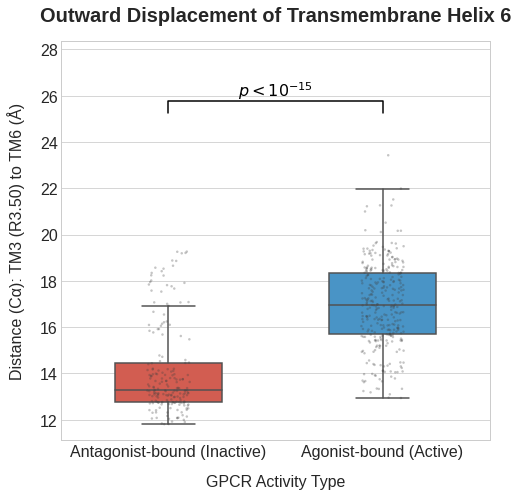

✅ Publication-ready plot for TM3-TM7 saved to: ../Output/Dynamics/Figure2_Panel_TM3-TM7_Consensus.png


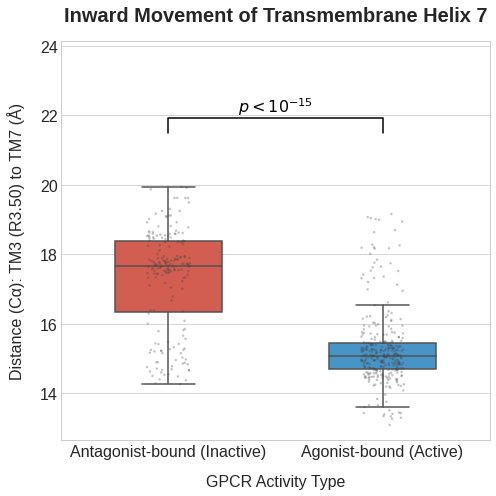

In [29]:
    # Part 2: Use the processed data to generate the final plots
    create_publication_plots(input_csv_path=CONSENSUS_DYNAMICS_FILE, output_dir=OUTPUT_DIR)